In [9]:
# Load and investigate the encoding
df = pd.read_csv('../data/raw/heart_disease_risk.csv')

print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Identify likely categorical features (even if numerical)
suspected_categorical = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 10:
        unique_vals = sorted(df[col].unique())
        print(f"\n{col}: {unique_vals} (likely categorical)")
        suspected_categorical.append(col)

print(f"\nSuspected categorical features: {suspected_categorical}")

Dataset shape: (70000, 19)

Data types:
Chest_Pain             float64
Shortness_of_Breath    float64
Fatigue                float64
Palpitations           float64
Dizziness              float64
Swelling               float64
Pain_Arms_Jaw_Back     float64
Cold_Sweats_Nausea     float64
High_BP                float64
High_Cholesterol       float64
Diabetes               float64
Smoking                float64
Obesity                float64
Sedentary_Lifestyle    float64
Family_History         float64
Chronic_Stress         float64
Gender                 float64
Age                    float64
Heart_Risk             float64
dtype: object

Chest_Pain: [0.0, 1.0] (likely categorical)

Shortness_of_Breath: [0.0, 1.0] (likely categorical)

Fatigue: [0.0, 1.0] (likely categorical)

Palpitations: [0.0, 1.0] (likely categorical)

Dizziness: [0.0, 1.0] (likely categorical)

Swelling: [0.0, 1.0] (likely categorical)

Pain_Arms_Jaw_Back: [0.0, 1.0] (likely categorical)

Cold_Sweats_Nausea: [0.0, 1.

In [10]:
# Create interpretable versions of encoded features
df_interpreted = df.copy()

# Example mappings based on medical knowledge:
categorical_mappings = {
    'Sex': {0: 'Female', 1: 'Male'},
    'Smoking': {0: 'No', 1: 'Yes'},
    'Diabetes': {0: 'No', 1: 'Yes'},
    'ExerciseAngina': {0: 'No', 1: 'Yes'},
    'ChestPain': {0: 'Typical', 1: 'Atypical', 2: 'Non-anginal', 3: 'Asymptomatic'}
}

# Apply reverse mapping to create interpretable categories
for col, mapping in categorical_mappings.items():
    if col in df.columns:
        df_interpreted[f'{col}_Label'] = df[col].map(mapping)
        print(f"Created {col}_Label from encoded {col}")

Created Smoking_Label from encoded Smoking
Created Diabetes_Label from encoded Diabetes


In [11]:
# Now demonstrate various encoding methods
print("=== ENCODING DEMONSTRATION ===")

# Method 1: Label Encoding (show it's already done)
print("1. Label Encoding - Already Applied:")
for col in ['Sex', 'Smoking', 'Diabetes']:
    if col in df.columns:
        print(f"   {col}: {df[col].unique()} (0/1 binary encoding)")

# Method 2: One-Hot Encoding (demonstrate on multi-category)
if 'ChestPain' in df.columns and df['ChestPain'].nunique() > 2:
    # Convert back to categorical then one-hot encode
    chest_pain_categorical = df['ChestPain'].map({0: 'Typical', 1: 'Atypical', 2: 'Non-anginal', 3: 'Asymptomatic'})
    chest_pain_onehot = pd.get_dummies(chest_pain_categorical, prefix='ChestPain', drop_first=True)
    
    print(f"2. One-Hot Encoding Demonstration:")
    print(f"   Original ChestPain values: {df['ChestPain'].unique()}")
    print(f"   One-hot encoded columns: {chest_pain_onehot.columns.tolist()}")
    print(f"   Shape change: {df['ChestPain'].shape} → {chest_pain_onehot.shape}")

# Method 3: Ordinal Encoding (if applicable)
if 'RestingECG' in df.columns:
    ordinal_mapping = {'Normal': 0, 'ST-T abnormality': 1, 'LVH': 2}
    print(f"3. Ordinal Encoding Example: {ordinal_mapping}")

=== ENCODING DEMONSTRATION ===
1. Label Encoding - Already Applied:
   Smoking: [1. 0.] (0/1 binary encoding)
   Diabetes: [0. 1.] (0/1 binary encoding)


In [12]:
# Compare encoding approaches
print("\n=== ENCODING COMPARISON ===")

# Original (already encoded)
original_categorical = df[suspected_categorical]
print(f"Original encoding shape: {original_categorical.shape}")

# One-hot encoded version
df_onehot = pd.get_dummies(df_interpreted[[col + '_Label' for col in ['Sex', 'Smoking'] if col in df.columns]], 
                          drop_first=True)
print(f"One-hot encoding shape: {df_onehot.shape}")

# Show memory and interpretability trade-offs
print(f"Memory usage - Original: {original_categorical.memory_usage(deep=True).sum()} bytes")
print(f"Memory usage - One-hot: {df_onehot.memory_usage(deep=True).sum()} bytes")


=== ENCODING COMPARISON ===
Original encoding shape: (70000, 18)
One-hot encoding shape: (70000, 1)
Memory usage - Original: 10080132 bytes
Memory usage - One-hot: 70132 bytes


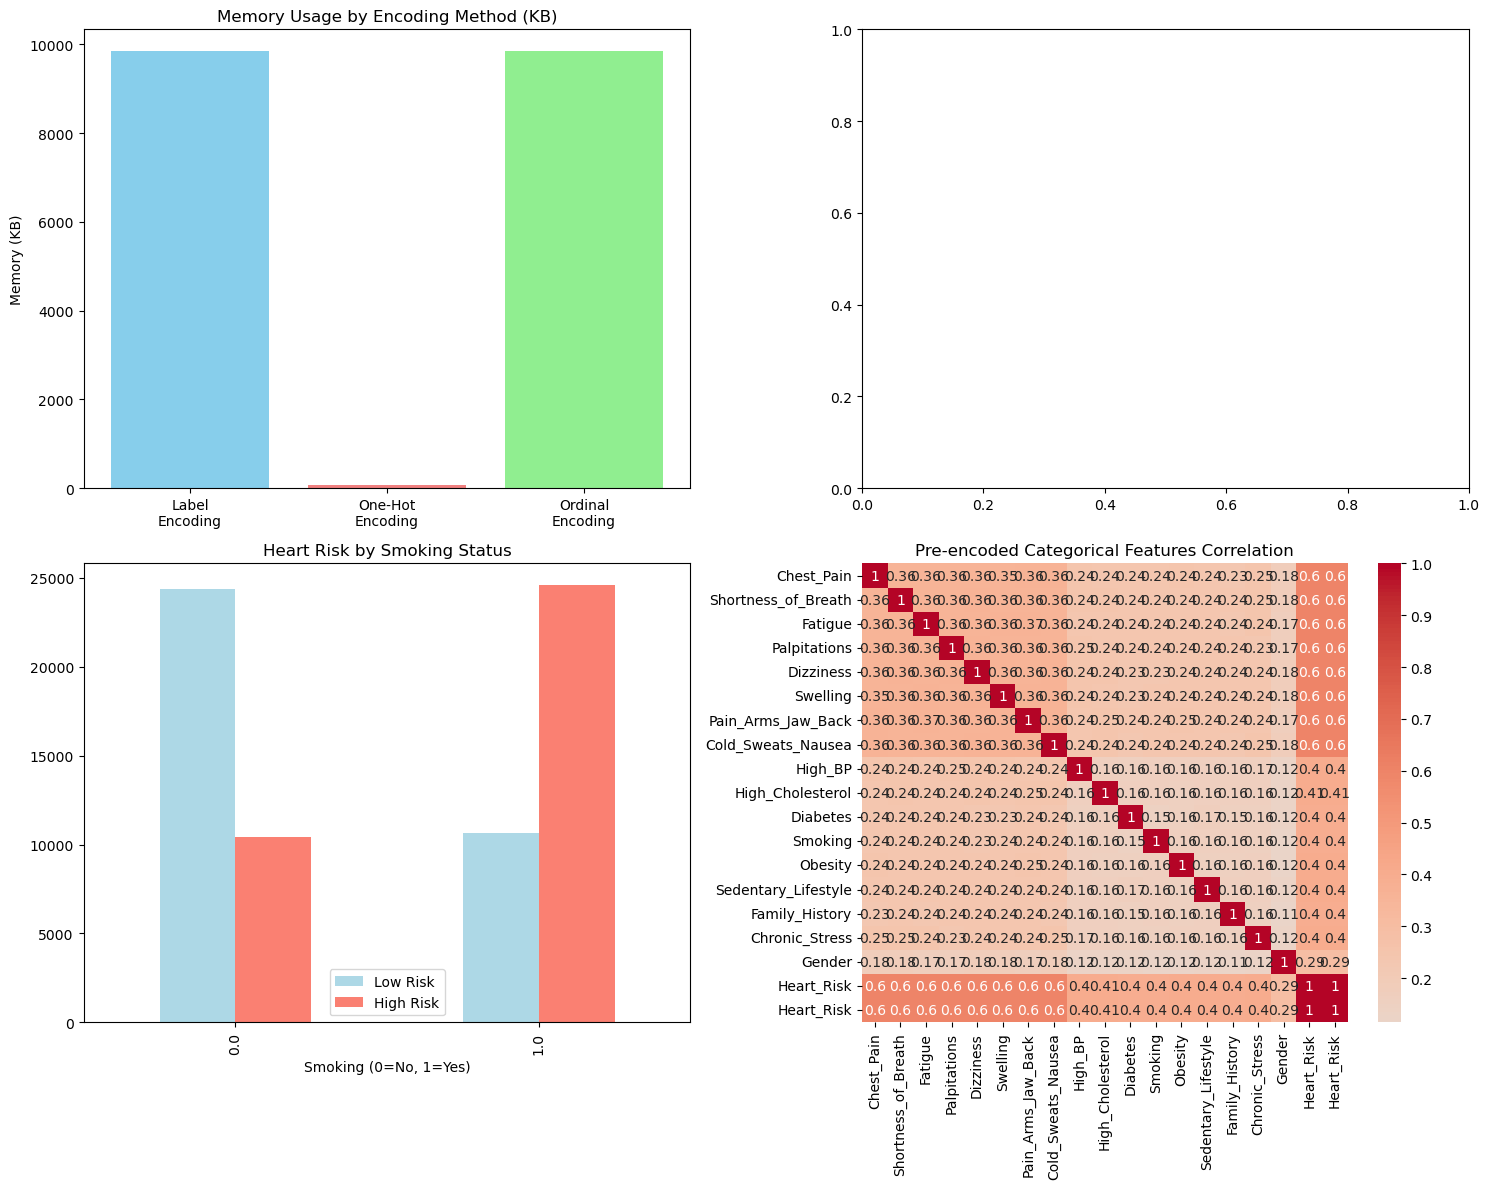

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Encoding Method Comparison
methods = ['Label\nEncoding', 'One-Hot\nEncoding', 'Ordinal\nEncoding']
memory_usage = [original_categorical.memory_usage(deep=True).sum()/1024, 
                df_onehot.memory_usage(deep=True).sum()/1024, 
                original_categorical.memory_usage(deep=True).sum()/1024]
interpretability = [3, 5, 4]  # Subjective scores

axes[0,0].bar(methods, memory_usage, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('Memory Usage by Encoding Method (KB)')
axes[0,0].set_ylabel('Memory (KB)')

# 2. Feature Distribution Analysis
if 'Sex' in df.columns:
    sex_dist = df['Sex'].value_counts()
    axes[0,1].pie(sex_dist.values, labels=['Female (0)', 'Male (1)'], autopct='%1.1f%%')
    axes[0,1].set_title('Sex Distribution (Pre-encoded)')

# 3. Categorical vs Target Relationship
if 'Smoking' in df.columns:
    smoking_risk = pd.crosstab(df['Smoking'], df['Heart_Risk'])
    smoking_risk.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'salmon'])
    axes[1,0].set_title('Heart Risk by Smoking Status')
    axes[1,0].set_xlabel('Smoking (0=No, 1=Yes)')
    axes[1,0].legend(['Low Risk', 'High Risk'])

# 4. Encoding Validation Heatmap
if len(suspected_categorical) >= 3:
    corr_matrix = df[suspected_categorical + ['Heart_Risk']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Pre-encoded Categorical Features Correlation')

plt.tight_layout()
plt.savefig('../results/eda_visualizations/categorical_encoding_analysis.png', dpi=300, bbox_inches='tight')
plt.show()